In [27]:
import plotting
import importlib
importlib.reload(plotting)
import numpy as np
import transforms
import sampling
import matplotlib.pyplot as plt
import sys
import scipy
#np.set_printoptions(suppress=True)
import chernoff
from tqdm import tqdm
np.set_printoptions(threshold=sys.maxsize)
import methods
import prop
importlib.reload(prop)
import pipeline
importlib.reload(pipeline)
import chernoff
importlib.reload(chernoff)
import matplotlib as mpl
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = 'DejaVu Serif'
mpl.rcParams["mathtext.default"] = 'rm'
mpl.rcParams["mathtext.fontset"]= 'dejavuserif'
import random
import spectral_clusterings
importlib.reload(spectral_clusterings)
import refinements
importlib.reload(refinements)

/home/adl/University/IV/M4R/repo/refinements.py:59: SyntaxWarning: 'int' object is not callable; perhaps you missed a comma?
  state = newstate


<module 'refinements' from '/home/adl/University/IV/M4R/repo/refinements.py'>

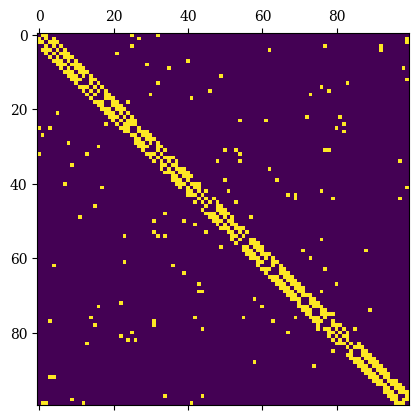

In [28]:
def gen_watts_strogatz(N, d, p):
    A = np.zeros((N,N))
    for i in range(N):
        for j in range(d):
            A[i][(i + (j+1)) %N] = 1
            A[i][(i - (j+1)) %N] = 1
    for i in range(N):
        for j in range(d):
            if random.random() < p:
                A[i][(i + (j+1)) %N] = 0
                A[(i + (j+1)) %N][i] = 0
                h = random.randint(0,N-1)
                A[i][h] = 1
                A[h][i] = 1
    return A

plt.matshow(gen_watts_strogatz(100,3,0.2))

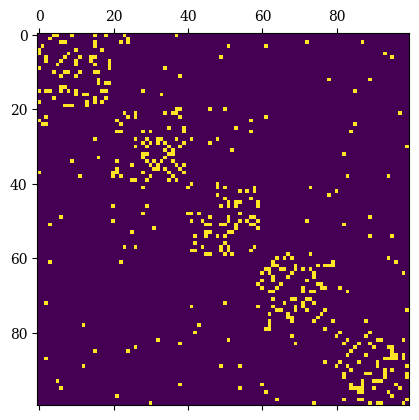

In [29]:
def gen_modular(N, M, C, p):
    A = np.zeros((N*C,N*C))
    ep = M/(0.5*N*N)
    for comm in range(C):
        for i in range(N):
            for j in range(i+1,N):
                if random.random() < ep:
                    A[comm*N + i][comm*N + j] = 1
                    A[comm*N + j][comm*N + i] = 1
    for comm in range(C):
        for i in range(N):
            for j in range(i+1,N):
                if A[comm*N + i][comm*N + j] == 1 and random.random() < p:
                    hc = comm
                    while hc == comm: hc = random.randint(0,C-1)
                    k = random.randint(0,N-1)
                    A[comm*N + i][comm*N + j] = 0
                    A[comm*N + j][comm*N + i] = 0
                    A[comm*N + i][hc*N + k] = 1
                    A[hc*N + k][comm*N + i] = 1
    return A

plt.matshow(gen_modular(20,50,5,0.2))

In [30]:
def modularity(A, C):
    N_C = len(A) // C
    degs = np.sum(A,axis = 0)
    absE = 0.5 * np.sum(degs)
    tot = 0
    for comm in range(C):
        for i in range(N_C):
            for j in range(i + 1, N_C):
                ri,rj = i + comm*N_C, j + comm*N_C
                tot += A[ri][rj] - (degs[ri] * degs[rj] / (2 * absE))
    return tot / absE

modularity(gen_modular(30,100,10,0),5)

np.float64(0.8036691215716086)

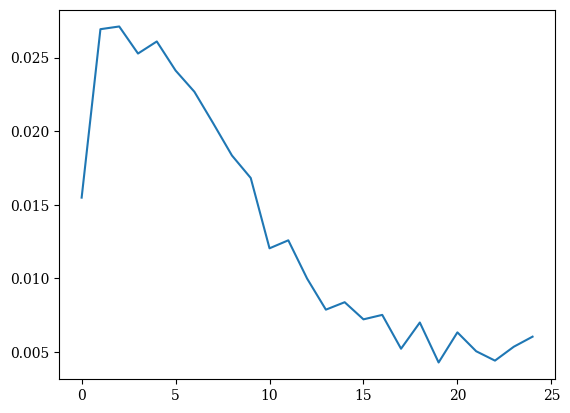

In [31]:

def floydWarshall(graph):

    V = len(graph)
    graph = np.copy(graph)
    graph[graph == 0] = 1e9

    dist = list(map(lambda i: list(map(lambda j: j, i)), graph))

    for k in range(V):

        # pick all vertices as source one by one
        for i in range(V):

            # Pick all vertices as destination for the
            # above picked source
            for j in range(V):

                # If vertex k is on the shortest path from
                # i to j, then update the value of dist[i][j]
                dist[i][j] = min(dist[i][j],
                                 dist[i][k] + dist[k][j]
                                 )
    return dist

def smallworld(A):
    clusters = np.zeros(len(A))
    for i in range(len(A)):
        tot = 0
        for j in range(len(A)):
            if A[i][j] == 1: tot += A[i] @ A[j]
        clusters[i] = tot/pow(sum(A[i]), 2)
    total_deg = np.sum(A) / 2
    global_clusters = np.mean(clusters)
    dists = floydWarshall(A)
    mpl = np.mean(dists)
    return (global_clusters/mpl) * (len(A) * np.log(len(A))) / (total_deg * np.log(total_deg))

plt.plot(range(25), [smallworld(gen_watts_strogatz(100,3,i/25)) for i in range(25)])



In [32]:
def modularity(A, C):
    N_C = len(A) // C
    degs = np.sum(A,axis = 0)
    absE = 0.5 * np.sum(degs)
    tot = 0
    for comm in range(C):
        for i in range(N_C):
            for j in range(i + 1, N_C):
                ri,rj = i + comm*N_C, j + comm*N_C
                tot += A[ri][rj] - (degs[ri] * degs[rj] / (2 * absE))
    return tot / absE

In [33]:
def stouffer_transform(X):
    X = X/1.01
    res = scipy.stats.norm.ppf(X)
    res[res == scipy.stats.norm.ppf(0.999/1.01)] = 0
    return res

In [34]:
A = np.array([[1,0,1],[0,1,0]])
A[0][A[0] == 1] = [2,3]
A

array([[2, 0, 3],
       [0, 1, 0]])

In [35]:
symbols = ["o","x","v","s","."]

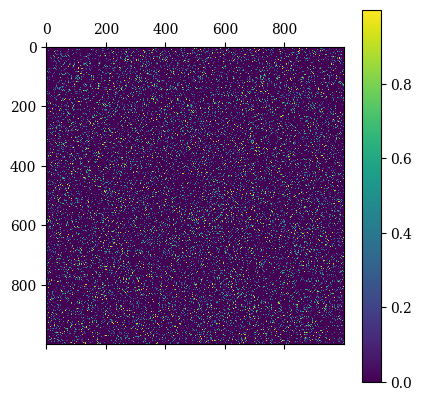

In [36]:
def sample_known_top(model, known_top):
        pi = model.pi
        N = len(known_top)
        submat = [int(N*pi),N-int(N*pi)]
        R = np.copy(known_top)
        for i in range(N):
            if i < submat[0]:
                nsamp = int(np.sum(R[i][:submat[0]]))
                samp = sampling.truncated_sample(model.DISTS[0][0], model.PARAMS[0][0], 1, nsamp)
                R[i][:submat[0]][R[i][:submat[0]] == 1] = samp
                nsamp = int(np.sum(R[i][submat[0]:]))
                samp = sampling.truncated_sample(model.DISTS[0][1], model.PARAMS[0][1], 1, nsamp)
                R[i][submat[0]:][R[i][submat[0]:] == 1] = samp
            else:
                nsamp = int(np.sum(R[i][:submat[0]]))
                samp = sampling.truncated_sample(model.DISTS[1][0], model.PARAMS[1][0], 1, nsamp)
                R[i][:submat[0]][R[i][:submat[0]] == 1] = samp
                nsamp = int(np.sum(R[i][submat[0]:]))
                samp = sampling.truncated_sample(model.DISTS[1][1], model.PARAMS[1][1], 1, nsamp)
                R[i][submat[0]:][R[i][submat[0]:] == 1] = samp
        return R

a = 1; b = 2; pi = 5
gamma_dists, gamma_params = sampling.standard_dist_matrix(scipy.stats.gamma, [a,0,1/b])
model = sampling.WSBM(f"$\\Gamma[{a},{b}]$", gamma_dists, gamma_params, np.array([pi,1 - pi]))

kk = list(range(1000))
random.shuffle(kk)
plt.matshow(sample_known_top(model, gen_modular(200, 0.5 * (200 * 200), 5, 0.3)[kk][:,kk]))
plt.colorbar()

In [37]:
print (np.sum(gen_modular(200, 0.5 * (200 * 200), 5, 0.3))/(1000 * 1000))

0.196526


  0%|          | 0/10 [00:00<?, ?it/s]

chance
CAVI
BP
Gibbs
ICM
0.17528039549299834
SP-refine


 10%|█         | 1/10 [00:48<07:17, 48.57s/it]

chance
CAVI
BP
Gibbs
ICM
0.17463798373088893
SP-refine


 20%|██        | 2/10 [01:35<06:18, 47.31s/it]

chance
CAVI
BP
Gibbs
ICM
0.17473158275476275
SP-refine


 30%|███       | 3/10 [02:21<05:27, 46.72s/it]

chance
CAVI
BP
Gibbs
ICM
0.17388526775685031
SP-refine


 40%|████      | 4/10 [03:07<04:39, 46.55s/it]

chance
CAVI
BP
Gibbs
ICM
0.1737212509556278
SP-refine


 50%|█████     | 5/10 [03:51<03:49, 45.86s/it]

chance
CAVI
BP
Gibbs
ICM
0.1725129674563147
SP-refine


 60%|██████    | 6/10 [04:36<03:01, 45.48s/it]

chance
CAVI
BP
Gibbs
ICM
0.17228467316804888
SP-refine


 70%|███████   | 7/10 [05:21<02:16, 45.42s/it]

chance
CAVI
BP
Gibbs
ICM
0.17186965618510291
SP-refine


 80%|████████  | 8/10 [06:07<01:30, 45.34s/it]

chance
CAVI
BP
Gibbs
ICM
0.17136762504855196
SP-refine


 90%|█████████ | 9/10 [06:51<00:45, 45.04s/it]

chance
CAVI
BP
Gibbs
ICM
0.17064897481857924
SP-refine


100%|██████████| 10/10 [07:35<00:00, 45.57s/it]


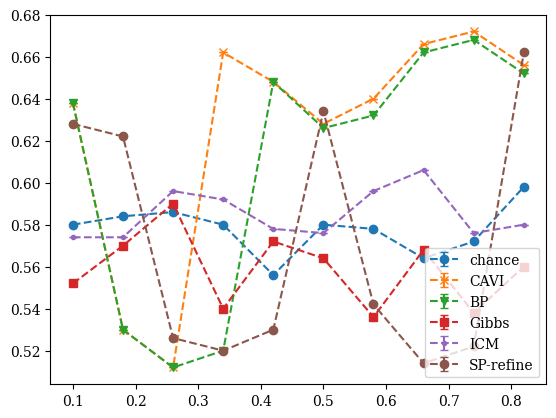

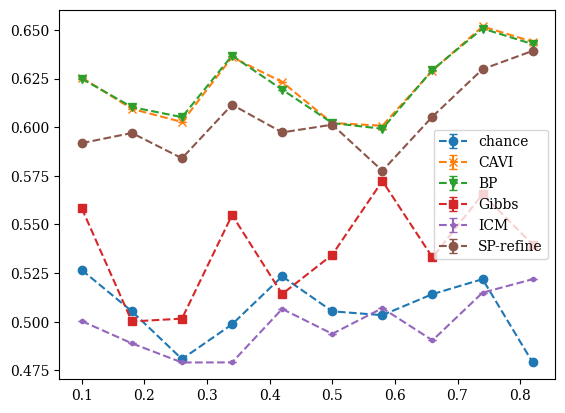

In [38]:
def pred_from_prior(p,gt,pi):
    N = len(p)
    if np.logical_or(p == 0,p == 1).all():
        #if sum(p) > N / 2: return 1 - p
        overlap = sum([1 if gg == pp else 0 for gg,pp in zip(gt,p)])
        if overlap < N / 2: return 1 - p
        else: return p

    ll = list(sorted([(y,x) for x,y in enumerate(p)]))[::-1]
    r = np.zeros(N)
    good = sum([gt[x] for _,x in ll[:50]])
    if good < 25:
        ll = ll[::-1]
    r[[x for _,x in ll[:int(N * pi)]]] = 1
    return r
from sklearn.metrics import roc_auc_score
def plot_accuracy_rho(algorithms, gran = 30):
    a = 1
    b = 0.5
    n = 1
    N = 1000
    pi = 0.3
    rho  = 0.5

    vals = np.arange(0.1, 0.9, 0.8/gran)
    accuracies = np.zeros((len(vals), len(algorithms), n))
    aucs = np.zeros((len(vals), len(algorithms), n))
    mu_1s = []
    for j,rewire in enumerate(tqdm(vals)): 
        gamma_dists, gamma_params = sampling.standard_dist_matrix(scipy.stats.gamma, [a,0,1/b])
        model = sampling.WSBM(f"$\\Gamma[{a},{b}]$", gamma_dists, gamma_params, np.array([pi,1 - pi]))
        #mu_1s.append(np.mean(sampling.truncated_sample(scipy.stats.gamma, [a,0,1/b], 1, 1_000_000)))

        for fold in range(n):
            perm = list(range(N))
            random.shuffle(perm)
            local_graph = sample_known_top(model, gen_watts_strogatz(1000, 50, rewire)[perm][:,perm])
            local_graph[local_graph == 0] = 0.999
            random.shuffle(perm)
            local_graph = local_graph[perm][:,perm]
            #uperm,perm = local_graph.permute(False, True)
            gt = np.concatenate((np.ones(int(N*pi)), np.zeros(N-int(N*pi))))[perm]
            embedded = spectral_clusterings.spectral(stouffer_transform(local_graph))
            p = np.array(spectral_clusterings.GMM_clustering(embedded))
            psamp = [1 if k > 1 else 0 for k in p[:25]]
            overlap = sum([1 if gg == pp else 0 for gg,pp in zip(gt[:25],psamp)])
            if overlap < 13:
                # H0/H1
                r_ = p * (1-pi)/pi
                p = 1/(r_ + 1)
            else:
                #H1/H0
                r_ = p * pi/(1-pi)
                p = r_/(1 + r_)
            for i,algorithm in enumerate(algorithms):
                print (algorithm[1])
                scores = algorithm[0](local_graph, p, model)
                pred = pred_from_prior(scores,gt,pi)
                overlap = sum([1 if gg == pp else 0 for gg,pp in zip(gt,pred)])
                accuracies[j][i][fold] = overlap/N
                aucs[j][i][fold] = roc_auc_score(gt, scores)
    acc_mean = np.mean(accuracies, axis = 2)
    acc_std = np.std(accuracies, axis = 2)
    auc_mean = np.mean(aucs, axis = 2)
    auc_std = np.std(aucs, axis = 2)
    for i in range(len(algorithms)):
        stds = acc_std[:, i]
        yerr = [stds, stds]

        plt.errorbar(vals, acc_mean[:, i], yerr=yerr, capsize=3, fmt="--"+symbols[i%len(symbols)], label=algorithms[i][1])
    plt.legend()
    plt.show()
    for i in range(len(algorithms)):
        stds = auc_std[:, i]
        yerr = [stds, stds]

        plt.errorbar(vals, auc_mean[:, i], yerr=yerr, capsize=3, fmt="--"+symbols[i%len(symbols)], label=algorithms[i][1])
    plt.legend()
    plt.show()

    return acc_mean, acc_std, auc_mean, auc_std

ALGORITHMS = [
    (lambda x,p,m : np.random.random(len(x)), "chance"),
    (lambda x,p,m : refinements.CAVI(x,p,m,1_000,5_000), "CAVI"),
    (lambda x,p,m : refinements.BP(x,p,m,1_000,5_000), "BP"),
    (lambda x,p,m : refinements.gibbs(x,p,m,1_000,3_000), "Gibbs"),
    (lambda x,p,m : refinements.ICM(x,p,m,100,200), "ICM"),
    (lambda x,p,m : refinements.SP_refine(x,p,m,100,100), "SP-refine")
]

RES_GAMMA_VARYING_RHO = plot_accuracy_rho(ALGORITHMS, 10)
#with open("RES_GAMMA_VARYING_RHO.pkl", "wb") as f:
#    pickle.dump(RES_GAMMA_VARYING_RHO,f)

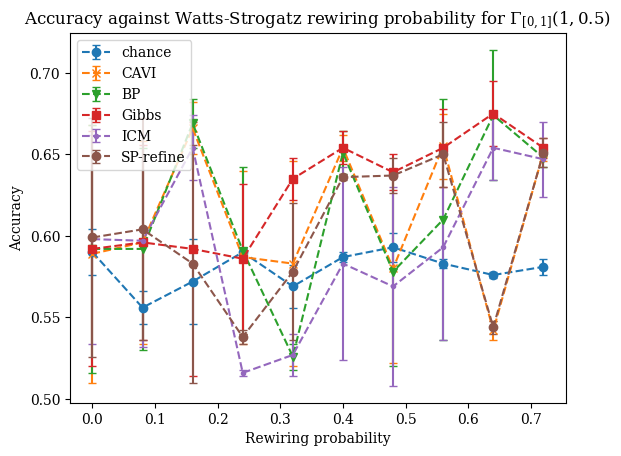

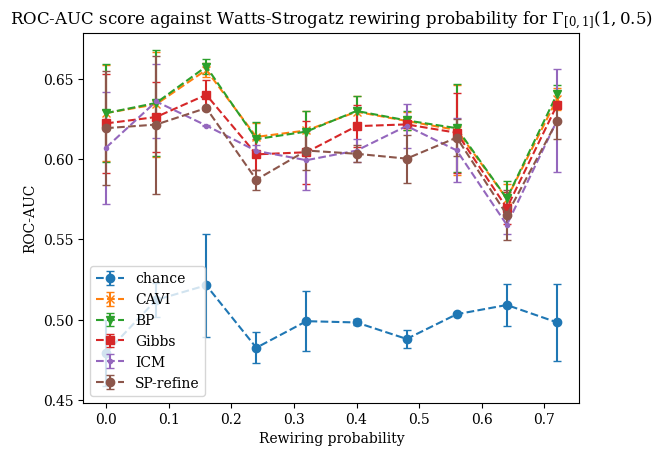

In [ ]:
acc_mean,acc_std,auc_mean,auc_std = RES_GAMMA_VARYING_RHO

vals = np.arange(0, 0.8, 0.8/10)
a = 1; mu_1s = []
#for b in vals:
#'    mu_1s.append(np.mean(sampling.truncated_sample(scipy.stats.gamma, [a,0,1/b], 1, 1_000_000)))

for i in range(len(ALGORITHMS)):
    stds = acc_std[:, i]
    yerr = [stds, stds]

    plt.errorbar(vals, acc_mean[:, i], yerr=yerr, capsize=3, fmt="--"+symbols[i%len(symbols)], label=ALGORITHMS[i][1])
plt.legend()
plt.title("Accuracy against Watts-Strogatz rewiring probability for $\\Gamma_{[0,1]}(1, 0.5)$")
plt.xlabel("Rewiring probability")
plt.ylabel("Accuracy")
plt.savefig("ref_wsacc.svg")
plt.show()

for i in range(len(ALGORITHMS)):
    stds = auc_std[:, i]
    yerr = [stds, stds]

    plt.errorbar(vals, auc_mean[:, i], yerr=yerr, capsize=3, fmt="--"+symbols[i%len(symbols)], label=ALGORITHMS[i][1])
plt.legend()
plt.title("ROC-AUC score against Watts-Strogatz rewiring probability for $\\Gamma_{[0,1]}(1, 0.5)$")
plt.xlabel("Rewiring probability")
plt.ylabel("ROC-AUC")
#plt.show()
plt.savefig("ref_wsauc.svg")
